In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2024-03-13 14:58:19.827829: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 14:58:20.204297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 14:58:20.204353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 14:58:20.302811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 14:58:20.474819: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 14:58:20.479485: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)

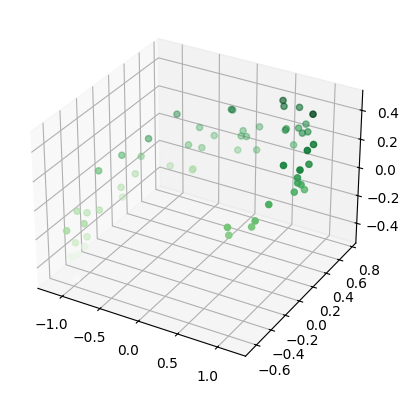

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:, 1], X_train[:, 2], c=X_train[:, 2], cmap='Greens')

In [4]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape=[3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape=[2]))
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1.5))

autoencoder.fit(X_train, X_train, epochs=30)

2024-03-13 14:58:24.563997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 14:58:24.757227: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
2/2 [==============================] - 0s 5ms/step - loss: 0.5750
Epoch 2/30
2/2 [==============================] - 0s 4ms/step - loss: 0.5613
Epoch 3/30
2/2 [==============================] - 0s 4ms/step - loss: 0.5480
Epoch 4/30
2/2 [==============================] - 0s 4ms/step - loss: 0.5353
Epoch 5/30
2/2 [==============================] - 0s 3ms/step - loss: 0.5233
Epoch 6/30
2/2 [==============================] - 0s 3ms/step - loss: 0.5119
Epoch 7/30
2/2 [==============================] - 0s 4ms/step - loss: 0.5011
Epoch 8/30
2/2 [==============================] - 0s 4ms/step - loss: 0.4907
Epoch 9/30
2/2 [==============================] - 0s 3ms/step - loss: 0.4809
Epoch 10/30
2/2 [==============================] - 0s 3ms/step - loss: 0.4717
Epoch 11/30
2/2 [==============================] - 0s 4ms/step - loss: 0.4628
Epoch 12/30
2/2 [==============================] - 0s 4ms/step - loss: 0.4541
Epoch 13/30
2/2 [==============================] - 0s 3ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 3ms/step


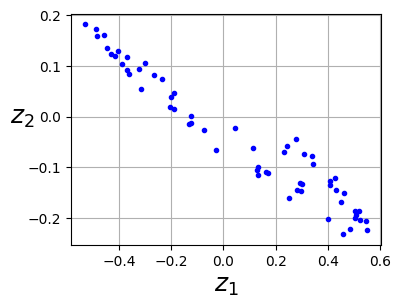

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2)

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_val = X_val.astype(np.float32) / 255

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
stacked_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28,28]),
                                          keras.layers.Dense(100, activation='selu'),
                                          keras.layers.Dense(30, activation='selu')])

stacked_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                          keras.layers.Dense(784, activation='sigmoid'),
                                          keras.layers.Reshape([28, 28])])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [10]:
history = stacked_ae.fit(X_train, X_train, epochs=30, validation_data=(X_val, X_val))

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3406 - rounded_accuracy: 0.8848 - val_loss: 0.3118 - val_rounded_accuracy: 0.9079
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3061 - rounded_accuracy: 0.9149 - val_loss: 0.3027 - val_rounded_accuracy: 0.9201
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2992 - rounded_accuracy: 0.9210 - val_loss: 0.2957 - val_rounded_accuracy: 0.9254
Epoch 4/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2954 - rounded_accuracy: 0.9243 - val_loss: 0.2946 - val_rounded_accuracy: 0.9268
Epoch 5/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2926 - rounded_accuracy: 0.9269 - val_loss: 0.2911 - val_rounded_accuracy: 0.9298
Epoch 6/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2906 - rounded_accuracy: 0.9288 - val_loss: 0.2891 - val_rounded_accuracy: 0.9317
Epoch 7/30
1500/1500 [==================

In [11]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

In [12]:
def show_reconstructions(model, n_images=5):
    true_images = X_val[:n_images]
    recon_images = model.predict(true_images)

    figure = plt.figure(figsize=(8.6, 6))
    for i in range(n_images):
        figure.add_subplot(2, n_images, i + 1)
        plot_image(true_images[i])
        figure.add_subplot(2, n_images, i + 1 + n_images)
        plot_image(recon_images[i])

In [13]:
# show_reconstructions(stacked_ae)

In [14]:
from sklearn.manifold import TSNE

X_val_compressed = stacked_encoder.predict(X_val)
tsne = TSNE()
X_val_2D = tsne.fit_transform(X_val_compressed)

375/375 [==============================] - 0s 956us/step


In [15]:
# plt.scatter(X_val_2D[:,0], X_val_2D[:, 1], c=y_val, s=10, cmap='tab10')

### Tying Weights

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', shape=[self.dense.input_shape[-1]], initializer="zeros")        
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
        

In [17]:
dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3299 - rounded_accuracy: 0.8929 - val_loss: 0.3059 - val_rounded_accuracy: 0.9198
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2995 - rounded_accuracy: 0.9205 - val_loss: 0.2992 - val_rounded_accuracy: 0.9150
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2932 - rounded_accuracy: 0.9264 - val_loss: 0.2906 - val_rounded_accuracy: 0.9285
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2898 - rounded_accuracy: 0.9296 - val_loss: 0.2893 - val_rounded_accuracy: 0.9331
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2876 - rounded_accuracy: 0.9314 - val_loss: 0.2872 - val_rounded_accuracy: 0.9301
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2860 - rounded_accuracy: 0.9330 - val_loss: 0.2845 - val_rounded_accuracy: 0.9356
Epoch 7/10
1500/1500 [==================

In [18]:
# show_reconstructions(tied_ae)
# plt.show()

### CNN Autoencoder

In [23]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

In [24]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

In [25]:
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=[X_val, X_val])

Epoch 1/5
1500/1500 [==============================] - 21s 13ms/step - loss: 0.3037 - rounded_accuracy: 0.9172 - val_loss: 0.2810 - val_rounded_accuracy: 0.9352
Epoch 2/5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2764 - rounded_accuracy: 0.9409 - val_loss: 0.2765 - val_rounded_accuracy: 0.9411
Epoch 3/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2718 - rounded_accuracy: 0.9453 - val_loss: 0.2730 - val_rounded_accuracy: 0.9454
Epoch 4/5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2693 - rounded_accuracy: 0.9478 - val_loss: 0.2693 - val_rounded_accuracy: 0.9478
Epoch 5/5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2675 - rounded_accuracy: 0.9499 - val_loss: 0.2667 - val_rounded_accuracy: 0.9507


In [27]:
# show_reconstructions(conv_ae)

In [29]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)        